Recommendation System
===========

Doc2vec + Wide & Deep 을 이용한 추천시스템
----------------------------------
모형별 Hit rate 비교
------------------------------------

<div style="text-align:right"><h3>
J. H. Park | 2017.08.16.
</h3></div>

---

### 순서

1. Wide
2. Deep
3. Wide & Deep


---

본 문서에 사용된 데이터는 Lpoint 2016년 공모전에서 제공받은 데이터임을 밝힙니다.

---

# 1. 데이터 소개

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy as cp
import pickle

In [2]:
train_label = pd.read_csv("./Lpoint_C/data/train_label.csv", encoding="cp949")
test_label = pd.read_csv("./Lpoint_C/data/test_label.csv", encoding="cp949")

In [3]:
train_label = train_label.fillna(0)

In [4]:
with open("./data/Wide_data.p", 'rb') as rd:
    Wide_data = pickle.load(rd)
    
with open("./data/Deep_data.p", 'rb') as rd:
    Deep_data = pickle.load(rd)

In [5]:
with open("./data/Wide_data_test.p", 'rb') as rd:
    Wide_data_test = pickle.load(rd)
    
with open("./data/Deep_data_test.p", 'rb') as rd:
    Deep_data_test = pickle.load(rd)

In [6]:
Wide_data.head()

,0,1,2,3,4,5,6,7,8,9,...,X15+X16_1.00.0,X15+X16_1.01.0,X15+X17_0.00.0,X15+X17_0.01.0,X15+X17_1.00.0,X15+X17_1.01.0,X16+X17_0.00.0,X16+X17_0.01.0,X16+X17_1.00.0,X16+X17_1.01.0
0,0.001469,-0.001295,0.000005,-0.001118,0.000692,0.000112,0.001632,0.000754,-0.001351,0.000008,...,0,0,0,1,0,0,0,1,0,0
1,0.013858,-0.069797,-0.228386,0.245291,-0.083660,0.052444,0.052756,0.044706,0.056476,-0.068763,...,0,1,0,0,0,1,0,0,0,1
2,0.008569,-0.001905,-0.006886,0.014368,-0.002174,-0.001780,0.002976,0.002795,0.003305,-0.000971,...,0,0,1,0,0,0,1,0,0,0
3,-0.000099,0.001165,-0.002520,-0.002333,0.001259,0.001369,-0.001451,0.001527,0.001928,0.001024,...,1,0,0,0,1,0,1,0,0,0
4,0.022761,-0.009565,-0.022066,-0.004037,-0.016980,0.022040,0.002982,0.006029,0.019570,0.002430,...,0,0,1,0,0,0,1,0,0,0


In [7]:
Deep_data.head()

,0,1,2,3,4,5,6,7,8,9,...,X11,X12,X13,X14,X15,X16,X17,성별,연령대,A거주지역
0,0.001469,-0.001295,0.000005,-0.001118,0.000692,0.000112,0.001632,0.000754,-0.001351,0.000008,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,7,6
1,0.013858,-0.069797,-0.228386,0.245291,-0.083660,0.052444,0.052756,0.044706,0.056476,-0.068763,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0,9,1
2,0.008569,-0.001905,-0.006886,0.014368,-0.002174,-0.001780,0.002976,0.002795,0.003305,-0.000971,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4,5
3,-0.000099,0.001165,-0.002520,-0.002333,0.001259,0.001369,-0.001451,0.001527,0.001928,0.001024,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,4,5
4,0.022761,-0.009565,-0.022066,-0.004037,-0.016980,0.022040,0.002982,0.006029,0.019570,0.002430,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,7,1


In [8]:
Wide_data_test.shape

(13915, 878)

In [9]:
Deep_data_test.shape

(13915, 320)

---

In [10]:
import tensorflow as tf
from tensorflow.contrib import layers
from datetime import datetime

In [11]:
# parameters
# keep_prob = 0.5
learning_rate = 1e-4
training_epochs = 10
batch_size = 256

wide_size = len(Wide_data.columns)
deep_size = len(Deep_data.columns) 
deep_embed_size = 3 # 임베딩할 컬럼 개수

output_size = len(train_label.columns)

He = tf.contrib.layers.variance_scaling_initializer()

# input place holders
tf.reset_default_graph()
Wide = tf.placeholder(tf.float32, [None, wide_size])
Deep_un_embed = tf.placeholder(tf.float32, [None, deep_size - deep_embed_size])
Deep_embed = tf.placeholder(tf.int32, [None, deep_embed_size])

Y = tf.placeholder(tf.float32, [None, output_size])
train_mode = tf.placeholder(tf.bool, name='train_mode')

In [12]:
def get_acc(score_matrix, top_n, test_matix):
    avg_acc = 0
    for i in range(len(score_matrix)):
        top = score_matrix.iloc[i].nlargest(top_n).index
        tmp = 0
        for j in range(len(top)):
            if top[j] in test_matix["item"][i].split():
                tmp += 1

        acc = tmp / len(top)
        avg_acc += acc / len(score_matrix)

    return avg_acc

# 1. Wide

In [13]:
Wide_A = tf.get_variable("Wide_A", shape=[wide_size, output_size])
Wied_B = tf.Variable(tf.random_normal([output_size]))

wide_wide = tf.add(tf.matmul(Wide, Wide_A), Wied_B)

In [14]:
Wide_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=wide_wide, labels=Y))
wide_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(Wide_cost)

In [15]:
Wide_ACC_plot = []
def Wide_Model(training_epochs = 10):
    for epoch in range(training_epochs):
        avg_cost = 0
        total_batch = int(len(Deep_data) / batch_size)

        for i in range(0, len(Deep_data), batch_size):
            batch_wide = Wide_data[i:i+batch_size]
            
            batch_label = train_label[i:i+batch_size]

            feed_dict_train = {Wide: batch_wide,
                               Y: batch_label}
            
            feed_dict_test = {Wide: Wide_data_test}
            
            opt, c = sess.run([wide_optimizer, Wide_cost], feed_dict=feed_dict_train)

            avg_cost += c/total_batch
            
        if (epoch % 2 == 0) or (epoch == training_epochs - 1):
            
            score = sess.run(tf.sigmoid(wide_wide), feed_dict=feed_dict_test)
            score_pd = pd.DataFrame(score, columns=train_label.columns)
            acc = get_acc(score_pd, 10, test_label)
            Wide_ACC_plot.append(acc)
        
            time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            main = "[Epoch: {:>4}][Cost: {:>.5f}][Hit rate of Top 10: {:>.5f}]"
            print(main.format(epoch, avg_cost, acc))
            
    print('Learning Finished!')

# 2. Deep 

In [16]:
no_class_max = 42
embedding_size = 5
Deep_col = Deep_data.columns

deep_var = tf.Variable(tf.random_uniform([no_class_max, embedding_size], -1.0, 1.0))
deep_lookup = tf.nn.embedding_lookup(deep_var, Deep_embed)
deep_re = tf.reshape(deep_lookup, [-1, embedding_size * deep_embed_size])

Deep_Deep = tf.concat([Deep_un_embed, deep_re], axis=1)

In [17]:
Deep_W1 = tf.get_variable("Deep_W1", shape=[332, 512], initializer=He)
Deep_b1 = tf.Variable(tf.random_normal([512]))
Deep_L1 = tf.nn.relu(tf.matmul(Deep_Deep, Deep_W1) + Deep_b1)

Deep_W2 = tf.get_variable("Deep_W2", shape=[512, 256], initializer=He)
Deep_b2 = tf.Variable(tf.random_normal([256]))
Deep_L2 = tf.nn.relu(tf.matmul(Deep_L1, Deep_W2) + Deep_b2)

Deep_W3 = tf.get_variable("Deep_W3", shape=[256, 128], initializer=He)
Deep_b3 = tf.Variable(tf.random_normal([128]))
Deep_L3 = tf.nn.relu(tf.matmul(Deep_L2, Deep_W3) + Deep_b3)

Deep_W4 = tf.get_variable("Deep_W4", shape=[128, output_size], initializer=He)
Deep_b4 = tf.Variable(tf.random_normal([output_size]))

Deep_deep = tf.add(tf.matmul(Deep_L3, Deep_W4), Deep_b4)

In [18]:
Deep_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Deep_deep, labels=Y))
Deep_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(Deep_cost)

In [19]:
Deep_ACC_plot = []
def Deep_Model(training_epochs = 10):
    for epoch in range(training_epochs):
        avg_cost = 0
        total_batch = int(len(Deep_data) / batch_size)

        for i in range(0, len(Deep_data), batch_size):
            batch_deep = Deep_data[i:i+batch_size][Deep_col[:-3]]
            batch_deep_embed = Deep_data[i:i+batch_size][Deep_col[-3:]]
            
            batch_label = train_label[i:i+batch_size]

            feed_dict_train = {Deep_un_embed: batch_deep,
                               Deep_embed: batch_deep_embed,
                               Y: batch_label}
            
            feed_dict_test = {Deep_un_embed: Deep_data_test[Deep_col[:-3]],
                              Deep_embed: Deep_data_test[Deep_col[-3:]]}
            
            opt, c = sess.run([Deep_optimizer, Deep_cost], feed_dict=feed_dict_train)

            avg_cost += c/total_batch

        if (epoch % 2 == 0) or (epoch == training_epochs - 1):
            
            score = sess.run(tf.sigmoid(Deep_deep), feed_dict=feed_dict_test)
            score_pd = pd.DataFrame(score, columns=train_label.columns)
            acc = get_acc(score_pd, 10, test_label)
            Deep_ACC_plot.append(acc)
            
            time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            main = "[Epoch: {:>4}][Cost: {:>.5f}][Hit rate of Top 10: {:>.5f}]"
            print(main.format(epoch, avg_cost, acc))
            
    print('Learning Finished!')

# 3. Wide & Deep 

In [20]:
no_class_max = 42
embedding_size = 5

deep_embed_var = tf.Variable(tf.random_uniform([no_class_max, embedding_size], -1.0, 1.0))
deep_embed = tf.nn.embedding_lookup(deep_embed_var, Deep_embed)
deep_embed_re = tf.reshape(deep_embed, [-1, embedding_size * deep_embed_size])

Deep = tf.concat([Deep_un_embed, deep_embed_re], axis=1)

### Wide

In [21]:
A = tf.get_variable("A", shape=[wide_size, output_size])
b = tf.Variable(tf.random_normal([output_size]))

wide = tf.add(tf.matmul(Wide, A), b)

### Deep

In [22]:
W1 = tf.get_variable("W1", shape=[332, 512], initializer=He)
b1 = tf.Variable(tf.random_normal([512]))
L1 = tf.nn.relu(tf.matmul(Deep, W1) + b1)

W2 = tf.get_variable("W2", shape=[512, 256], initializer=He)
b2 = tf.Variable(tf.random_normal([256]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)

W3 = tf.get_variable("W3", shape=[256, 128], initializer=He)
b3 = tf.Variable(tf.random_normal([128]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)

W4 = tf.get_variable("W4", shape=[128, output_size], initializer=He)
b4 = tf.Variable(tf.random_normal([output_size]))

deep = tf.add(tf.matmul(L3, W4), b4)

In [23]:
hypothesis = wide + deep

In [24]:
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=hypothesis, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [25]:
Wide_n_Deep_ACC_plot = []
def Wide_n_Deep_Model(training_epochs = 10):
    for epoch in range(training_epochs):
        avg_cost = 0
        total_batch = int(len(Deep_data) / batch_size)

        for i in range(0, len(Deep_data), batch_size):
            batch_wide = Wide_data[i:i+batch_size]
            batch_deep = Deep_data[i:i+batch_size][Deep_col[:-3]]
            batch_deep_embed = Deep_data[i:i+batch_size][Deep_col[-3:]]
            
            batch_label = train_label[i:i+batch_size]

            feed_dict_train = {Wide: batch_wide,
                               Deep_un_embed: batch_deep,
                               Deep_embed: batch_deep_embed,
                               Y: batch_label}
            
            feed_dict_test = {Wide: Wide_data_test,
                              Deep_un_embed: Deep_data_test[Deep_col[:-3]],
                              Deep_embed: Deep_data_test[Deep_col[-3:]]}
            
            opt, c = sess.run([optimizer, cost], feed_dict=feed_dict_train)

            avg_cost += c/total_batch
            
        if (epoch % 2 == 0) or (epoch == training_epochs - 1):
            
            score = sess.run(tf.sigmoid(hypothesis), feed_dict=feed_dict_test)
            score_pd = pd.DataFrame(score, columns=train_label.columns)
            acc = get_acc(score_pd, 10, test_label)
            Wide_n_Deep_ACC_plot.append(acc)

            time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            main = "[Epoch: {:>4}][Cost: {:>.5f}][Hit rate of Top 10: {:>.5f}]"
            print(main.format(epoch, avg_cost, acc))
            
    print('Learning Finished!')

---

# Session

In [26]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

# 1. Wide 

In [27]:
sess.run(tf.global_variables_initializer())
Wide_Model(50)

[Epoch:    0][Cost: 0.26157][Hit rate of Top 10: 0.01779]
[Epoch:    2][Cost: 0.02919][Hit rate of Top 10: 0.14216]
[Epoch:    4][Cost: 0.02011][Hit rate of Top 10: 0.15713]
[Epoch:    6][Cost: 0.01732][Hit rate of Top 10: 0.16232]
[Epoch:    8][Cost: 0.01597][Hit rate of Top 10: 0.16455]
[Epoch:   10][Cost: 0.01519][Hit rate of Top 10: 0.16572]
[Epoch:   12][Cost: 0.01467][Hit rate of Top 10: 0.16664]
[Epoch:   14][Cost: 0.01431][Hit rate of Top 10: 0.16723]
[Epoch:   16][Cost: 0.01403][Hit rate of Top 10: 0.16750]
[Epoch:   18][Cost: 0.01382][Hit rate of Top 10: 0.16732]
[Epoch:   20][Cost: 0.01365][Hit rate of Top 10: 0.16714]
[Epoch:   22][Cost: 0.01350][Hit rate of Top 10: 0.16697]
[Epoch:   24][Cost: 0.01339][Hit rate of Top 10: 0.16658]
[Epoch:   26][Cost: 0.01328][Hit rate of Top 10: 0.16623]
[Epoch:   28][Cost: 0.01319][Hit rate of Top 10: 0.16575]
[Epoch:   30][Cost: 0.01312][Hit rate of Top 10: 0.16530]
[Epoch:   32][Cost: 0.01305][Hit rate of Top 10: 0.16479]
[Epoch:   34][

# 2. Deep 

In [28]:
sess.run(tf.global_variables_initializer())
Deep_Model(50)

[Epoch:    0][Cost: 0.30294][Hit rate of Top 10: 0.05985]
[Epoch:    2][Cost: 0.02060][Hit rate of Top 10: 0.08316]
[Epoch:    4][Cost: 0.01934][Hit rate of Top 10: 0.10505]
[Epoch:    6][Cost: 0.01813][Hit rate of Top 10: 0.13115]
[Epoch:    8][Cost: 0.01719][Hit rate of Top 10: 0.14074]
[Epoch:   10][Cost: 0.01657][Hit rate of Top 10: 0.14540]
[Epoch:   12][Cost: 0.01608][Hit rate of Top 10: 0.14836]
[Epoch:   14][Cost: 0.01568][Hit rate of Top 10: 0.15053]
[Epoch:   16][Cost: 0.01533][Hit rate of Top 10: 0.15151]
[Epoch:   18][Cost: 0.01505][Hit rate of Top 10: 0.15233]
[Epoch:   20][Cost: 0.01481][Hit rate of Top 10: 0.15312]
[Epoch:   22][Cost: 0.01461][Hit rate of Top 10: 0.15332]
[Epoch:   24][Cost: 0.01443][Hit rate of Top 10: 0.15356]
[Epoch:   26][Cost: 0.01428][Hit rate of Top 10: 0.15371]
[Epoch:   28][Cost: 0.01415][Hit rate of Top 10: 0.15346]
[Epoch:   30][Cost: 0.01404][Hit rate of Top 10: 0.15327]
[Epoch:   32][Cost: 0.01394][Hit rate of Top 10: 0.15307]
[Epoch:   34][

# 3. Wide & Deep

In [29]:
sess.run(tf.global_variables_initializer())
Wide_n_Deep_Model(50)

[Epoch:    0][Cost: 0.21768][Hit rate of Top 10: 0.09669]
[Epoch:    2][Cost: 0.01808][Hit rate of Top 10: 0.14372]
[Epoch:    4][Cost: 0.01633][Hit rate of Top 10: 0.15812]
[Epoch:    6][Cost: 0.01541][Hit rate of Top 10: 0.16187]
[Epoch:    8][Cost: 0.01481][Hit rate of Top 10: 0.16336]
[Epoch:   10][Cost: 0.01440][Hit rate of Top 10: 0.16341]
[Epoch:   12][Cost: 0.01409][Hit rate of Top 10: 0.16272]
[Epoch:   14][Cost: 0.01384][Hit rate of Top 10: 0.16195]
[Epoch:   16][Cost: 0.01365][Hit rate of Top 10: 0.16119]
[Epoch:   18][Cost: 0.01348][Hit rate of Top 10: 0.16035]
[Epoch:   20][Cost: 0.01335][Hit rate of Top 10: 0.15964]
[Epoch:   22][Cost: 0.01323][Hit rate of Top 10: 0.15889]
[Epoch:   24][Cost: 0.01312][Hit rate of Top 10: 0.15804]
[Epoch:   26][Cost: 0.01303][Hit rate of Top 10: 0.15718]
[Epoch:   28][Cost: 0.01295][Hit rate of Top 10: 0.15609]
[Epoch:   30][Cost: 0.01288][Hit rate of Top 10: 0.15558]
[Epoch:   32][Cost: 0.01281][Hit rate of Top 10: 0.15483]
[Epoch:   34][

---

In [30]:
import matplotlib.pyplot as plt
import numpy as np

In [32]:
builds = np.array(list(range(0, 51, 2)))
y_stack = np.row_stack((Wide_ACC_plot, Deep_ACC_plot, Wide_n_Deep_ACC_plot)) 

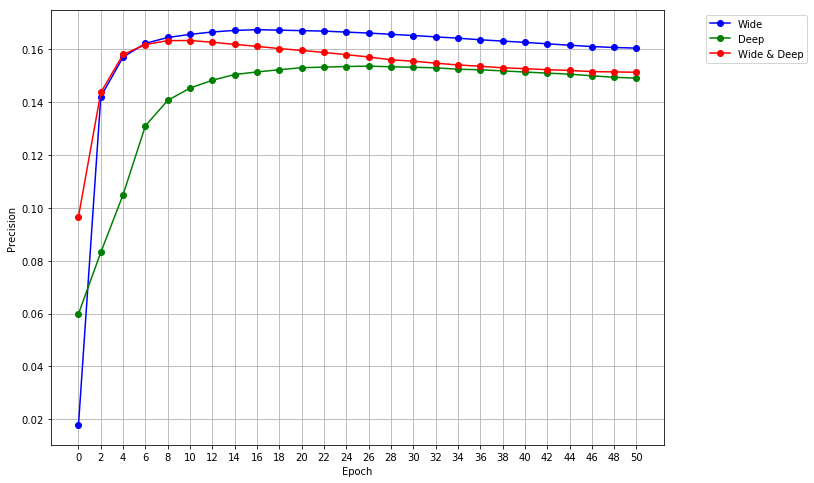

In [38]:
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)

ax1.plot(builds, y_stack[0,:], label='Wide', color='b', marker='o')
ax1.plot(builds, y_stack[1,:], label='Deep', color='g', marker='o')
ax1.plot(builds, y_stack[2,:], label='Wide & Deep', color='r', marker='o')

plt.xticks(builds)
plt.xlabel('Epoch')
plt.ylabel('Precision')

handles, labels = ax1.get_legend_handles_labels()
lgd = ax1.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.15,1))
ax1.grid('on')
plt.savefig('Wide_Deep_Model.png')
plt.show()


---

# Reference

### [[1] Recommender System with Distributed Representation](https://www.slideshare.net/rakutentech/recommender-system-with-distributed-representation)   
### [[2] Distributed Representations of Sentences and Documents](https://arxiv.org/abs/1405.4053)   
### [[3] Wide & Deep Learning for Recommender Systems](https://arxiv.org/abs/1606.07792)   
### [[4] TensorFlow Wide & Deep Learning Tutorial](https://www.tensorflow.org/tutorials/wide_and_deep)   
### [[5] Korean NLP in Python](http://konlpy.org/en/v0.4.4/)